# Get the regressor output of the image







In [1]:
import torch
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
import sys
sys.path.insert(0, "main")

!which python

/software/sse/manual/PyTorch/2.3.0/python-3.10/envs/pytorch_2.3.0/bin/python


In [2]:
from common.utils.preprocessing import load_img, process_bbox, generate_patch_image
from config import cfg


img_path = 'demo/input.png'
original_img = load_img(img_path)
original_img_height, original_img_width = original_img.shape[:2]

detector = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
with torch.no_grad():
    results = detector(original_img)
    
person_results = results.xyxy[0][results.xyxy[0][:, 5] == 0]
class_ids, confidences, boxes = [], [], []
for detection in person_results:
    x1, y1, x2, y2, confidence, class_id = detection.tolist()
    class_ids.append(class_id)
    confidences.append(confidence)
    boxes.append([x1, y1, x2 - x1, y2 - y1])
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

persons_deteted = []
for num, indice in enumerate(indices):
    bbox = boxes[indice]  # x,y,h,w
    bbox = process_bbox(bbox, original_img_width, original_img_height)
    img, img2bb_trans, bb2img_trans = generate_patch_image(original_img, bbox, 1.0, 0.0, False, cfg.input_img_shape)
    persons_deteted.append(img)





Using cache found in /home/x_hensh/.cache/torch/hub/ultralytics_yolov5_master


requirements: Ultralytics requirements ['requests>=2.32.2', 'tqdm>=4.66.3', 'setuptools>=70.0.0'] not found, attempting AutoUpdate...


ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/software/sse/manual/PyTorch/2.3.0/python-3.10/envs/pytorch_2.3.0/lib/python3.10/site-packages/tqdm'



Retry 1/2 failed: Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/software/sse/manual/PyTorch/2.3.0/python-3.10/envs/pytorch_2.3.0/lib/python3.10/site-packages/tqdm'



Retry 2/2 failed: Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
requirements: ❌ Command 'pip install --no-cache-dir "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


YOLOv5 🚀 2024-12-10 Python-3.10.0 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81051MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


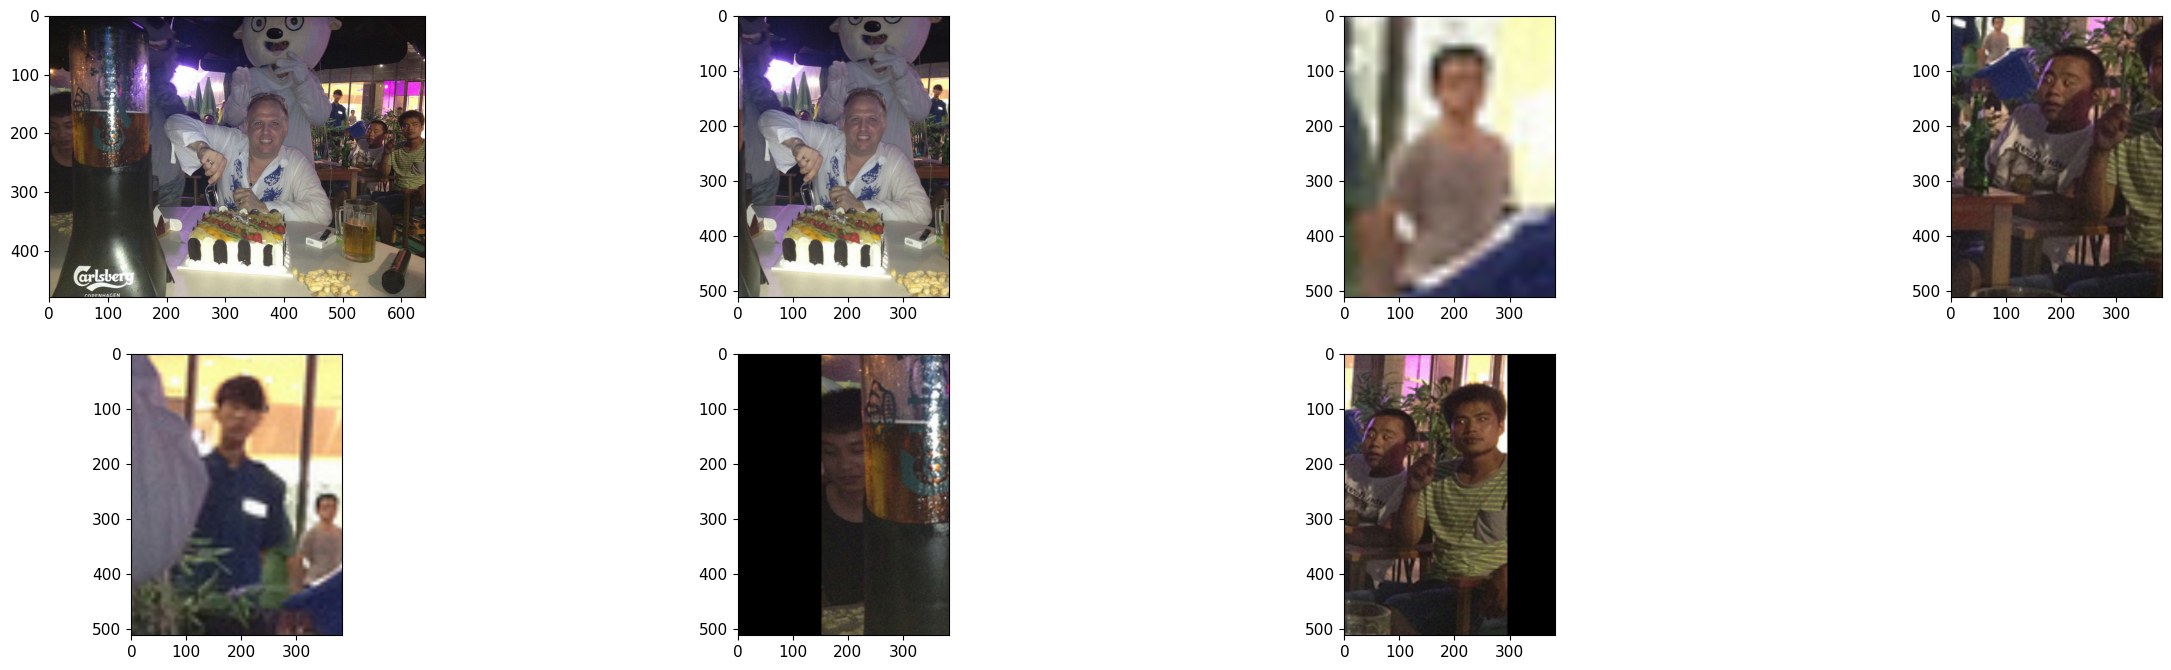

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

N_COL = 4
N_ROW = np.ceil(len(persons_deteted) + 1 / N_COL).astype(int)

fig = plt.figure(figsize=(30, 30))

ax = fig.add_subplot(N_ROW, N_COL, 1)
ax.imshow(original_img.astype(np.float32) / 255)

for i, person in enumerate(persons_deteted):
    ax = fig.add_subplot(N_ROW, N_COL, i + 2)
    ax.imshow(person.astype(np.float32) / 255)
plt.show()




# Comparing different person for the same model

In [6]:
sys.path.insert(0, "main/transformer_utils")

from common.base import Demoer
from common.utils.human_models import smpl_x
from common.utils.human_models import smpl_h
from common.utils.human_models import smil_h


transform = transforms.ToTensor()
cfg.set_additional_args(
    encoder_setting='osx_l',
    decoder_setting='wo_face_decoder', 
    pretrained_model_path='pretrained_models/osx_l.pth.tar')

demoerx = Demoer()
demoerx._make_model(smpl_x)
demoerx.model.eval()

demoerh = Demoer()
demoerh._make_model(smpl_h)
demoerh.model.eval()

demoeri = Demoer()
demoeri._make_model(smil_h)
demoeri.model.eval()



# Now we tartet on the second image.

image = persons_deteted[0]
img = transform(img.astype(np.float32))/255
img = img.cuda()[None,:,:,:]
inputs = {'img': img}



with torch.no_grad():
    outx = demoerx.model(inputs, {}, {}, 'test')
    outh = demoerh.model(inputs, {}, {}, 'test')
    outi = demoeri.model(inputs, {}, {}, 'test')

meshx = outx['smplx_mesh_cam'].detach().cpu().numpy()
meshx = meshx[0]

meshh = outh['smplx_mesh_cam'].detach().cpu().numpy()
meshh = meshh[0]

meshi = outi['smplx_mesh_cam'].detach().cpu().numpy()
meshi = meshi[0]


print ([[meshx[:,i].max(), meshx[:,i].min()]  for i in range(0,3)])
print ([[meshh[:,i].max(), meshh[:,i].min()]  for i in range(0,3)])
print ([[meshi[:,i].max(), meshi[:,i].min()]  for i in range(0,3)])

/home/x_hensh/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
12-12 23:03:08 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:08 Creating graph...
12-12 23:03:22 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:22 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:22 Creating graph...
12-12 23:03:22 Creating graph...
12-12 23:03:30 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:30 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:30 Load checkpoint from pretrained_models/osx_l.pth.tar
12-12 23:03:30 Creating graph...
12-12 23:03:30 Creating graph...
12-12 23:03:30 Creating graph...


[[0.34144786, -0.3244276], [1.143673, -0.37562716], [19.22113, 18.377237]]
[[0.34225658, -0.31073233], [1.2312033, -0.22565162], [19.2199, 18.413664]]
[[0.17963687, -0.043959893], [1.098043, 0.60651517], [19.073244, 18.863964]]


In [7]:
print (outx.keys())

dict_keys(['img', 'joint_img', 'smplx_joint_proj', 'smplx_mesh_cam', 'smplx_root_pose', 'smplx_body_pose', 'smplx_lhand_pose', 'smplx_rhand_pose', 'smplx_jaw_pose', 'smplx_shape', 'smplx_expr', 'cam_trans', 'lhand_bbox', 'rhand_bbox', 'face_bbox'])


In [2]:

from aitviewer.renderables.smpl import SMPLSequence
from aitviewer.models.smpl import SMPLLayer
from aitviewer.configuration import CONFIG as C
C.smplx_models = "common/utils/human_model_files"
C.model_type = "smpl"

#
template_smplx = SMPLLayer(model_type="smplx", gender="neutral", device=C.device)#, name="SMPLX")
template_smplh = SMPLLayer(model_type="smplh", gender="neutral", device=C.device)#, name="SMPLH")
template_smpli = SMPLLayer(model_type="smilh", gender="neutral", device=C.device)#, name="SMILH")




In [9]:
import sys
import numpy as np
from aitviewer.renderables.smpl import SMPLSequence
from aitviewer.viewer import Viewer

from aitviewer.renderables.smpl import SMPLSequence
from aitviewer.models.smpl import SMPLLayer
from aitviewer.configuration import CONFIG as C
C.smplx_models = "common/utils/human_model_files"

#print (outx.keys())
template_smplx = SMPLLayer(model_type="smplx", gender="male", device=C.device)#, name="SMPLX")
template_smplh = SMPLLayer(model_type="smplh", gender="male", device=C.device)#, name="SMPLH")
template_smilh = SMPLLayer(model_type="smilh", gender="male", device=C.device)#, name="SMILH")


#v = Viewer()

#v.scene.add(SMPLSequence.t_pose(outx['smplx_body_pose'], template_smplx))
#v.scene.add(SMPLSequence.t_pose(template_smplh, position=np.array((-0.0, 0.0, -1.0))))
#v.scene.add(SMPLSequence.t_pose(template_smilh, position=np.array((-0.0, 0.0, -2.0))))
#v.run()


AttributeError: 'Tensor' object has no attribute 'bm'

# Comparing different for the same person

In [ ]:
sys.path.insert(0, "main/transformer_utils")

from common.base import Demoer
from common.utils.human_models import smpl_x
from common.utils.human_models import smpl_h
from common.utils.human_models import smil_h


outx = []
outh = []
outi = []
